In [99]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max.columns', None)

from scipy.stats import skew
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, average_precision_score,auc

from sklearn.neighbors import KNeighborsClassifier

In [100]:
# data=pd.read_csv('parkinsons_updrs.csv')
# data.head()

In [101]:
dataset = pd.read_csv("pd_speech_features.csv")

dataset = dataset.drop(['id'],axis=1)
dataset.shape
# dataset.head()

(756, 754)

In [102]:
column_names = list(dataset.columns)
column_names = column_names[:-1] # Removing the last attribute which is the 'CLASS'
print(column_names)

['gender', 'PPE', 'DFA', 'RPDE', 'numPulses', 'numPeriodsPulses', 'meanPeriodPulses', 'stdDevPeriodPulses', 'locPctJitter', 'locAbsJitter', 'rapJitter', 'ppq5Jitter', 'ddpJitter', 'locShimmer', 'locDbShimmer', 'apq3Shimmer', 'apq5Shimmer', 'apq11Shimmer', 'ddaShimmer', 'meanAutoCorrHarmonicity', 'meanNoiseToHarmHarmonicity', 'meanHarmToNoiseHarmonicity', 'minIntensity', 'maxIntensity', 'meanIntensity', 'f1', 'f2', 'f3', 'f4', 'b1', 'b2', 'b3', 'b4', 'GQ_prc5_95', 'GQ_std_cycle_open', 'GQ_std_cycle_closed', 'GNE_mean', 'GNE_std', 'GNE_SNR_TKEO', 'GNE_SNR_SEO', 'GNE_NSR_TKEO', 'GNE_NSR_SEO', 'VFER_mean', 'VFER_std', 'VFER_entropy', 'VFER_SNR_TKEO', 'VFER_SNR_SEO', 'VFER_NSR_TKEO', 'VFER_NSR_SEO', 'IMF_SNR_SEO', 'IMF_SNR_TKEO', 'IMF_SNR_entropy', 'IMF_NSR_SEO', 'IMF_NSR_TKEO', 'IMF_NSR_entropy', 'mean_Log_energy', 'mean_MFCC_0th_coef', 'mean_MFCC_1st_coef', 'mean_MFCC_2nd_coef', 'mean_MFCC_3rd_coef', 'mean_MFCC_4th_coef', 'mean_MFCC_5th_coef', 'mean_MFCC_6th_coef', 'mean_MFCC_7th_coef', '

<h1>SKEWNESS REDUCTION</h1>

In [103]:
skewedCols = []
for names in column_names:
    skewVal = dataset[names].skew()
    if(skewVal>1 or skewVal<-1):
        skewedCols.append(names)
# print(skewedCols)
# print(len(skewedCols))

In [104]:
#   Name of the cols containing atleast one negative value
skewedCols_NegativeVals = []
for col_name in skewedCols:
    for values in dataset[col_name]:
        if(values < 0):
            skewedCols_NegativeVals.append(col_name)
            break
print(len(skewedCols_NegativeVals))

#   Name of the cols containing atleast one zero values
skewedCols_ZeroVals = []
for col_name in skewedCols:
    if col_name in skewedCols_NegativeVals:
        continue
    else:
        for values in dataset[col_name]:
            if(values == 0):
                skewedCols_ZeroVals.append(col_name)
                break
print(len(skewedCols_ZeroVals))

#   Name of the cols containing only positive values
skewedCols_PositiveVals = []
for col_name in skewedCols:
    if (col_name not in skewedCols_NegativeVals and col_name not in skewedCols_ZeroVals):
        skewedCols_PositiveVals.append(col_name)
# print(len(skewedCols_PositiveVals))

147
1


In [105]:
#   Box-Cox Transformation
for col_name in skewedCols_PositiveVals:
    dataset[col_name] = stats.boxcox(dataset[col_name],lmbda=0)

count = 0
for col_name in skewedCols_PositiveVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

In [106]:
#   CubeRoot Transformation on skewedCols_NegativeVals & skewedCols_ZeroVals
for col_name in skewedCols_NegativeVals:
    dataset[col_name] = np.cbrt(dataset[col_name])
for col_name in skewedCols_ZeroVals:
    dataset[col_name] = np.cbrt(dataset[col_name])

count = 0
for col_name in skewedCols_NegativeVals:
    skewVal = dataset[col_name].skew()
    if skewVal>1 or skewVal<-1:
        count = count + 1
# print(count)
# print(dataset)

In [107]:
# #   Log Transformation on skewedCols_PositiveVals
# for col_name in skewedCols_PositiveVals:
#     dataset[col_name] = np.log(dataset[col_name])

# count = 0
# for col_name in skewedCols_PositiveVals:
#     skewVal = dataset[col_name].skew()
#     if skewVal>1 or skewVal<-1:
#         count = count + 1
# print(count)

<h1>Kurtosis Reduction</h1>

In [108]:
kurtosisCols = []
for names in column_names:
    kurtVal = dataset[names].kurt()
    if(kurtVal>3 or kurtVal<3):
        kurtosisCols.append(names)
# print(skewedCols)
print(len(kurtosisCols))

753


<h1>Outlier Detection</h1>

In [109]:
import statistics
for col_name in column_names:
    qi = dataset[col_name].quantile(0.25)
    qf = dataset[col_name].quantile(0.75)

    iqr = qf - qi
    c = 1.5
    upper_limit=qf+c*iqr
    lower_limit=qi-c*iqr

    col_median = statistics.mean(dataset[col_name].to_numpy())
    for val in dataset[col_name]:
        if val < lower_limit or val > upper_limit:
            dataset[col_name] = dataset[col_name].replace(val,col_median)

In [110]:
# print(dataset)

<h1>Testing the Dataset with a Model</h1>

In [111]:
# print(dataset.shape)

# standard = StandardScaler()

# real_x = dataset.iloc[:,:-1].values
# real_y = dataset.iloc[:,-1].values

# real_x = standard.fit_transform(real_x)

# x_train, x_test, y_train, y_test = train_test_split(real_x, real_y, test_size=0.1)

# knn = KNeighborsClassifier()
# knn.fit(x_train, y_train)   
# print(knn.score(x_test, y_test))
# y_predict_knn = knn.predict(x_test)
# cm_knn = confusion_matrix(y_test, y_predict_knn)

Standard scaling.

In [112]:
from sklearn.preprocessing import StandardScaler
# get the features and label from the original dataframe
X = dataset.iloc[:,:-1]
y = dataset.iloc[:,-1]
# performing standardization
sc = StandardScaler()
X_scaled = sc.fit_transform(X)


In [113]:
from sklearn.preprocessing import OneHotEncoder
from seaborn import load_dataset

df = dataset
ohe = OneHotEncoder()
transformed = ohe.fit_transform(df[['class']])
output=transformed.toarray()

# print(transformed.toarray())

In [114]:
# from sklearn.decomposition import PCA
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler
# from sklearn.decomposition import PCA
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.neural_network import MLPClassifier
# shape = list(dataset.shape)
# # for i in range(11,55):
# components = 17
# _sc = StandardScaler()
# _pca = PCA(n_components = components)

# _model = MLPClassifier(hidden_layer_sizes=(shape[0]//2,shape[1]//2))
# pipeline_model = Pipeline([
#     ('std_scaler', _sc),
#     ('pca', _pca),
#     ('classifier', _model)
# ])
# # perform a split
# X_train, X_test, y_train, y_test =train_test_split(X, output, test_size=0.1, random_state=0)
# # train the model using the PCA components
# pipeline_model.fit(X_train,y_train)

# print(pipeline_model.score(X_test,y_test))

In [115]:
input_size = dataset.shape[1] - 1
print(input_size)

753


In [116]:
# y.values

In [117]:
# import torch
# import torch.nn as nn
# import torch.optim as optim

# # Define the neural network architecture
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3, output_size):
#         super(NeuralNetwork, self).__init__()
#         self.fc1 = nn.Linear(input_size, hidden_size1)
#         self.relu = nn.ReLU()
#         self.fc2 = nn.Linear(hidden_size1, hidden_size2)
#         self.relu = nn.ReLU()
#         self.fc3 = nn.Linear(hidden_size2, hidden_size3)
#         self.relu = nn.ReLU()
#         self.fc4 = nn.Linear(hidden_size3, output_size)
    
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = self.relu(x)
#         x = self.fc4(x)
#         return x

# # Set the hyperparameters
# input_size = dataset.shape[1] - 1  # Number of input features
# hidden_size1 = 64
# hidden_size2 = 32
# hidden_size3 = 16  # Number of neurons in the hidden layer
# output_size = 2  # Number of output classes

# # Create an instance of the neural network
# model = NeuralNetwork(input_size, hidden_size1,hidden_size2, hidden_size3, output_size)

# # Define the loss function and optimizer
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# # Convert the dataset to PyTorch tensors
# X = torch.tensor(X_scaled, dtype=torch.float32)
# y = torch.tensor(y.values, dtype=torch.long)

# # Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# # Initialize lists to store losses and accuracies
# train_losses = []
# test_losses = []
# train_accs = []
# test_accs = []

# # Train the neural network
# num_epochs = 100
# batch_size = 32

# # for epoch in range(num_epochs):
# #     for i in range(0, X_train.shape[0], batch_size):
# #         # Forward pass
# #         outputs = model(X_train[i:i+batch_size])
# #         loss = criterion(outputs, y_train[i:i+batch_size])
        
# #         # Backward and optimize
# #         optimizer.zero_grad()
# #         loss.backward()
# #         optimizer.step()
    
# #     # Print the loss every 10 epochs
# #     if (epoch+1) % 10 == 0:
# #         print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# # # Evaluate the model
# # with torch.no_grad():
# #     outputs = model(X_test)
# #     _, predicted = torch.max(outputs.data, 1)
# #     accuracy = (predicted == y_test).sum().item() / y_test.size(0)
# #     print(f'Test Accuracy: {accuracy}')

# # Initialize a list to keep track of the loss for the last 10 epochs
# last_10_losses = [None] * 10
# cnt=0
# while True:
#     for i in range(0, X_train.shape[0], batch_size):
#         # Forward pass
#         outputs = model(X_train[i:i+batch_size])
#         loss = criterion(outputs, y_train[i:i+batch_size])
        
#         # Backward and optimize
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
    
#     # Update the list of last 10 losses
#     last_10_losses.pop(0)
#     last_10_losses.append(loss.item())
    
#     # Print the loss every 10 epochs
#     if len(set(last_10_losses)) == 1 and None not in last_10_losses:
#         print(f'Loss: {loss.item()} for last 10 epochs. Stopping...')
#         break
#     elif(cnt%10==0):
#         print(f'Loss: {loss.item()}')
#     cnt+=1

# # Evaluate the model
# with torch.no_grad():
#     outputs = model(X_test)
#     _, predicted = torch.max(outputs.data, 1)
#     accuracy = (predicted == y_test).sum().item() / y_test.size(0)
#     print(f'Test Accuracy: {accuracy}')

In [118]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2, hidden_size3, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, output_size)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

# Set the hyperparameters
input_size = dataset.shape[1] - 1  # Number of input features
hidden_size1 = 64
hidden_size2 = 32
hidden_size3 = 16  # Number of neurons in the hidden layer
output_size = 2  # Number of output classes

# Create an instance of the neural network
model = NeuralNetwork(input_size, hidden_size1,hidden_size2, hidden_size3, output_size)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Convert the dataset to PyTorch tensors
X = torch.tensor(X_scaled, dtype=torch.float32)
y = torch.tensor(y.values, dtype=torch.long)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=42)

# Initialize lists to store losses and accuracies
train_losses = []
test_losses = []
train_accs = []
test_accs = []

num_epochs = 50
for epoch in range(num_epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    train_output = model(X_train)
    train_loss = criterion(train_output, y_train)
    train_loss.backward()
    optimizer.step()
    train_losses.append(train_loss.item())
    
    # Calculate training accuracy
    _, train_predicted = torch.max(train_output.data, 1)
    train_accuracy = (train_predicted == y_train).sum().item() / y_train.size(0)
    train_accs.append(train_accuracy)
    
    # Validation
    model.eval()
    with torch.no_grad():
        test_output = model(X_test)
        test_loss = criterion(test_output, y_test)
        test_losses.append(test_loss.item())
        
        # Calculate testing accuracy
        _, test_predicted = torch.max(test_output.data, 1)
        test_accuracy = (test_predicted == y_test).sum().item() / y_test.size(0)
        test_accs.append(test_accuracy)
    
    # Print the loss and accuracy every 10 epochs
    if (epoch+1) % 10 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss.item()}, Test Loss: {test_loss.item()}, Train Acc: {train_accuracy}, Test Acc: {test_accuracy}')

Epoch 10/50, Train Loss: 0.472214013338089, Test Loss: 0.4185158610343933, Train Acc: 0.8565459610027855, Test Acc: 0.868421052631579
Epoch 20/50, Train Loss: 0.3378479778766632, Test Loss: 0.28674331307411194, Train Acc: 0.8690807799442897, Test Acc: 0.9210526315789473
Epoch 30/50, Train Loss: 0.2193913757801056, Test Loss: 0.2186731994152069, Train Acc: 0.9108635097493036, Test Acc: 0.8947368421052632
Epoch 40/50, Train Loss: 0.11532258242368698, Test Loss: 0.19387972354888916, Train Acc: 0.9610027855153204, Test Acc: 0.868421052631579
Epoch 50/50, Train Loss: 0.045329976826906204, Test Loss: 0.2136465162038803, Train Acc: 0.9944289693593314, Test Acc: 0.8947368421052632


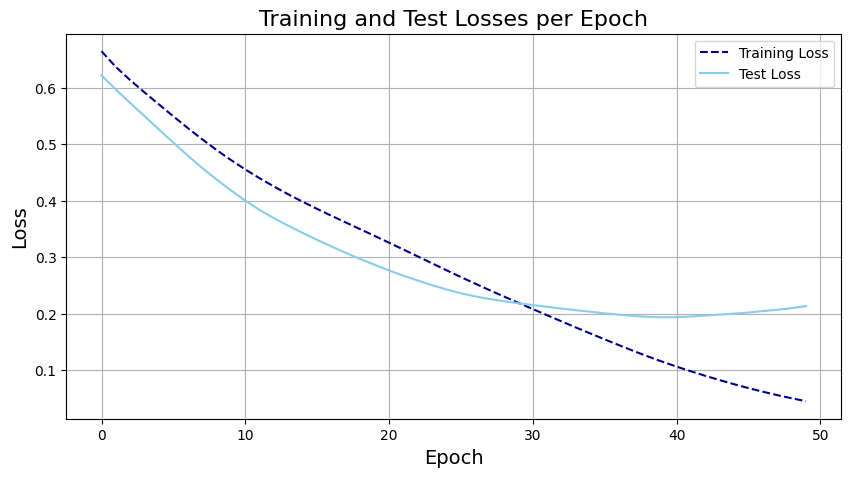

In [119]:
import matplotlib.pyplot as plt

# Plot training and test losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='darkblue', linestyle='dashed')
plt.plot(test_losses, label='Test Loss', color='skyblue')
plt.title('Training and Test Losses per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

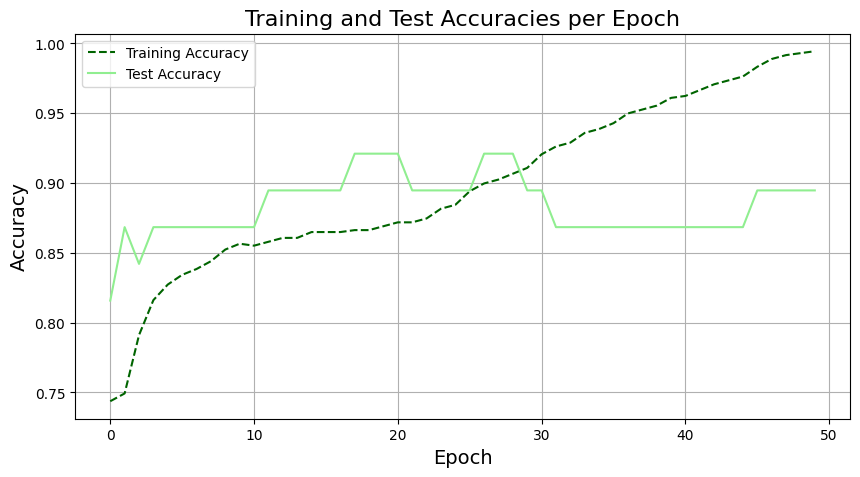

In [120]:
# Plot training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(train_accs, label='Training Accuracy', color='darkgreen', linestyle='dashed')
plt.plot(test_accs, label='Test Accuracy', color='lightgreen')
plt.title('Training and Test Accuracies per Epoch', fontsize=16)
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()